## CISC867 - Lab 2
## Daniel Lee
February 21, 2019

## Question 1

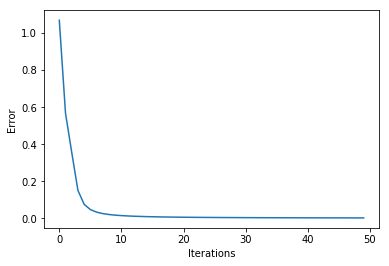

Input patterns:
[[1 0]
 [0 0]
 [0 1]
 [1 1]]
Actual label
[[1]
 [0]
 [1]
 [0]]
Y hot encoded:
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
Prediction:
[[0.00155346 0.99844654]
 [0.99790165 0.00209835]
 [0.00229568 0.99770432]
 [0.99824922 0.00175078]]


In [39]:
import numpy as np
import random
import matplotlib.pyplot as plt


class Network:
    
    def __init__(self, alpha, input_count, hidden_count, output_count):
        self.alpha = alpha
        self.input_count = input_count
        self.hidden_count = hidden_count
        self.output_count = output_count
    
    def _softmax(self, z):
        expz = np.exp(z)
        return expz / expz.sum(axis = 1, keepdims = True);
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x));
    
    def _sigmoid_derivative(self, z):
        return z * (1 - z);
    
    def init(self, X, Y, Y_hot, epochs):
        '''The function initializes random weights and 
        biases for the network, trains the network, and predicts 
        the XOR values of the inputs.
        '''
        self.w1 = np.random.randn(self.input_count, self.hidden_count)
        self.b1 = np.random.randn(self.hidden_count)
        
        self.w2 = np.random.randn(self.hidden_count, self.output_count)
        self.b2 = np.random.randn(self.output_count)
        
        errors = self.train(X, Y, Y_hot, epochs)
        fig,ax = plt.subplots()
        plt.plot(errors)
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Error")
        plt.show()
        
        pred = self.predict(X)
        print("Input patterns:")
        print(X)
        print("Actual label")
        print(Y.reshape(len(Y), 1))
        print("Y hot encoded:")
        print(Y_hot)
        print("Prediction:")
        print(pred)
        
        
    def predict(self, X):
        '''This function predicts the XOR values using the final 
        weights and biases.
        '''        
        h1 = self._sigmoid(np.dot(X, self.w1) + self.b1)
        output = self._softmax(np.dot(h1, self.w2) + self.b2)         
        return output;
    
    # Mean Squared Error 
    def mse(self, y_label, y_pred):
        return np.square(y_pred - y_label)
    
    # NEGATIVE LOG LIKELIHOOD
    def nll(self, m, Y_hot, Y_pred):
        return -(np.sum(Y_hot * np.log(Y_pred))) / m;

    def forward_pass(self, X):
        # Input -> K1; get the dot product of the weights with input and add bias
        h1 = self._sigmoid(np.dot(X, self.w1) + self.b1)

        # K1 -> Output layer; get the dot product  of the weights with input and add bias
        output = self._softmax(np.dot(h1, self.w2) + self.b2)
        
        # Apply softmax activation function on resultant z and return
        return h1, output;
    
    def train(self, X, Y, Y_hot, epochs):
        '''The function performs a forward pass to obtain the 
        activation vectors, then computes the error that needs to be
        minimized, and then performs backward propagation to
        acquire the deltas using sigmoid prime, and then
        updates the weights.
        '''
        errors = []
        for epoch in range(epochs):

            # Forward pass to get outputs
            h1, Y_pred = self.forward_pass(X)

            # Back propagation
            d2 = Y_pred - Y_hot
            d1 = np.dot(d2, self.w2.T) * self._sigmoid_derivative(h1)
            
            # Update weights and biases
            self.w2 -= self.alpha * np.dot(h1.T, d2)
            self.b2 -= self.alpha * np.sum(d2, axis = 0)

            self.w1 -= self.alpha * np.dot(X.T, d1)
            self.b1 -= self.alpha * np.sum(d1, axis = 0)

            if epoch % 1000 == 0:
                # Number of input patterns
                m = X.shape[0]
                
                # Negative log likelihood error function
                error = self.nll(m, Y_hot, Y_pred)
                errors.append(error)
                
        return errors;
    
X = np.array([[1,0], [0,0], [0,1], [1,1]])
Y = np.array([1, 0, 1, 0])

# One hot encoded output
num_classes = len(np.unique(Y, return_counts = True)[1])
Y_hot = np.eye(num_classes)[Y]

mynetwork = Network(0.01, 2, 4, 2)
mynetwork.init(X, Y, Y_hot, 50000)




## Question 2

In [49]:
from sklearn.datasets import fetch_mldata
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.datasets.base import get_data_home 
import scipy.io as sio
import os

## Using Sci-kit learn to load MNIST dataset
## You can also use this code to load the data as well by placing the mnist data locally to /mnist/mldata/
# folder_name = 'mnist'
# mnist = fetch_mldata('MNIST original', transpose_data = True, data_home = folder_name)
# print(get_data_home())
# x = mnist.data
# y = mnist.target.reshape(mnist.target.shape[0], 1)

file_name = 'mnist-original.mat'
file_path = os.path.join(get_data_home(), file_name)
mnist = sio.loadmat(file_path)

x = mnist['data'].T
y = mnist['label'].T.reshape(mnist['label'].T.shape[0], 1)

## Concatenate data with labels
combined_mat = np.concatenate((x, y), axis = 1)

## Randomize data and labels via shuffling
# Random seed for reproducing - can be removed
# np.random.seed(101)
np.random.shuffle(combined_mat)

## Split data and labels into 10 equal folds
num_folds = 10
folds = np.split(combined_mat, num_folds)

## Statistics on each fold
# Distribution of complete data set    
# Getting categories
complete_count_labels = np.unique(y, return_counts = True)[0]

# Getting percentage
complete_counts = np.divide(np.unique(y, return_counts = True)[1], y.shape[0]) * 100.0
print('The complete dataset categories are', complete_count_labels)
print('and the corresponding distribution is')
print(complete_counts)
print('*****************************')

# Distribution in each fold
fold_ind = 1
for fold in folds:  
    labels = np.split(fold, [fold.shape[1] - 1], axis = 1)[1]
    fold_total_size = len(labels)
    
    #Getting categories
    fold_labels = np.unique(labels, return_counts = True)[0]
    
    # Getting percentage
    fold_counts = np.divide(np.unique(labels, return_counts = True)[1], fold_total_size) * 100.0
    print('For fold', fold_ind, 'the categories are', fold_labels)
    print('and the corresponding distribution is')
    print(fold_counts)
    print('============================')
    
    fold_ind += 1

## IGNORE: For testing purposes only - Checks number of images per fold
# for i in folds:
#     num_instances = 0
#     for j in i:
#         num_instances += 1
#     print(num_instances)

The complete dataset categories are [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
and the corresponding distribution is
[ 9.86142857 11.25285714  9.98571429 10.20142857  9.74857143  9.01857143
  9.82285714 10.41857143  9.75        9.94      ]
*****************************
For fold 1 the categories are [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
and the corresponding distribution is
[ 9.87142857 12.02857143  9.92857143 10.15714286  9.78571429  8.92857143
  9.72857143 10.48571429  9.87142857  9.21428571]
For fold 2 the categories are [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
and the corresponding distribution is
[ 9.97142857 10.78571429  9.97142857 10.34285714  9.57142857  8.8
  9.67142857 10.48571429 10.2        10.2       ]
For fold 3 the categories are [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
and the corresponding distribution is
[ 9.94285714 10.94285714 10.01428571 10.32857143  9.54285714  8.75714286
 10.12857143 10.98571429  9.42857143  9.92857143]
For fold 4 the categories are [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
and the correspon

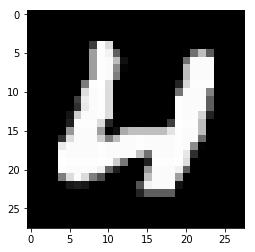

image0.png belongs to category 4.0


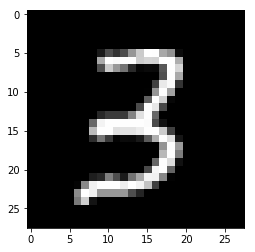

image1.png belongs to category 3.0


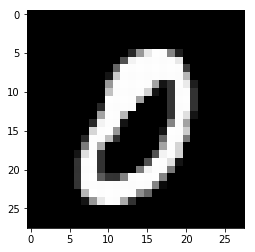

image2.png belongs to category 0.0


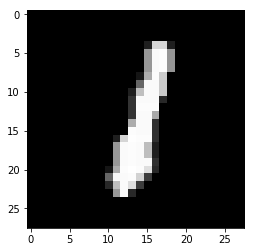

image3.png belongs to category 1.0


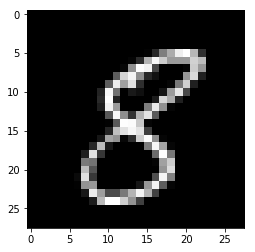

image4.png belongs to category 8.0


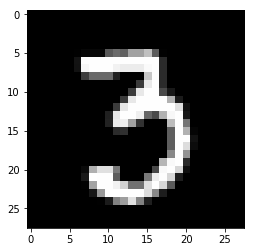

image5.png belongs to category 3.0


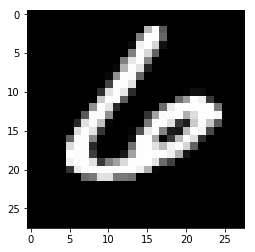

image6.png belongs to category 6.0


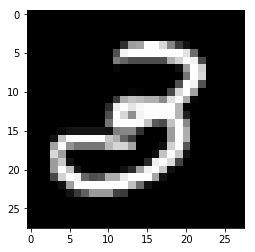

image7.png belongs to category 3.0


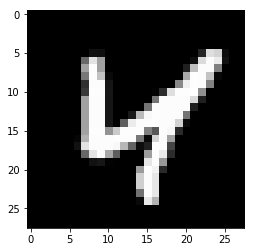

image8.png belongs to category 4.0


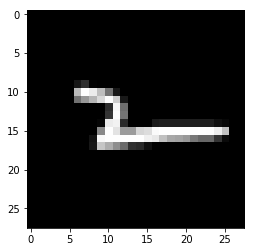

image9.png belongs to category 2.0


In [50]:
# Random seed for reproducing - can be removed
# np.random.seed(101)

## Display one random picture from each fold with category
num_ind = 1
for fold_ind in range(0, len(folds)):
    
    image_ind = np.random.choice(folds[fold_ind].shape[1], num_ind, replace = False)
    image_list = folds[fold_ind][image_ind][0]
    
    image = image_list[:folds[fold_ind].shape[1] - 1]
    category = image_list[-1]
    
    arr = np.array(image.reshape(28, 28) , dtype = np.uint8)

    img = Image.fromarray(arr)
    
    # Produces a random image from each fold
    img_name = 'image' + str(fold_ind) + '.png'
    
    # Saves image locally
    img.save(img_name)

    # Display images
    img_output = mpimg.imread(img_name)
    plt.imshow(img_output, cmap = 'gray')
    plt.show()
    print(img_name, 'belongs to category', category)



In [58]:
## Generates required sets: train, test, validation
# Create the folds
train_folds = folds[:8]
test_fold = folds[-2]
val_fold = folds[-1]

# Stack the 8 folds together
train_folds_stacked = np.vstack(train_folds)

# Split X and Y
train_x, train_y = np.split(train_folds_stacked, [train_folds_stacked.shape[1] - 1], axis = 1)
test_x, test_y = np.split(test_fold, [test_fold.shape[1] - 1], axis = 1)
val_x, val_y = np.split(val_fold, [val_fold.shape[1] - 1], axis = 1)

# Convert matrix into a long row vector
train_set_x = np.squeeze(np.asarray(train_x))
test_set_x = np.squeeze(np.asarray(test_x))
val_set_x = np.squeeze(np.asarray(val_x))

# One hot encode Y
num_unique_classes = len(np.unique(train_y, return_counts = True)[0])

train_y = train_y.reshape(-1).astype(dtype='uint8')
train_set_y = np.eye(num_unique_classes)[train_y]

test_y = test_y.reshape(-1).astype(dtype='uint8')
test_set_y = np.eye(num_unique_classes)[test_y]

val_y = val_y.reshape(-1).astype(dtype='uint8')
val_set_y = np.eye(num_unique_classes)[val_y]


print('Train set X dimensions:', train_set_x.shape)
print('Train set Y one hot dimensions:', train_set_y.shape)
print('===================')
print('Validation set X dimensions:', val_set_x.shape)
print('Validation set Y one hot set dimensions:', val_set_y.shape)
print('===================')
print('Test set X dimensions:', test_set_x.shape)
print('Test set Y one hot dimensions:', test_set_y.shape)
# print('Train set Y dimensions:', train_y.shape)
# print('Test set Y dimensions:', test_y.shape)
# print('Validation Y set dimensions:', val_y.shape)
# print('===================')




Train set X dimensions: (56000, 784)
Train set Y one hot dimensions: (56000, 10)
Validation set X dimensions: (7000, 784)
Validation set Y one hot set dimensions: (7000, 10)
Test set X dimensions: (7000, 784)
Test set Y one hot dimensions: (7000, 10)


## Question 3

Epoch 0
Validation err: 25.003245049461466
Epoch 1
Validation err: 19.469504879199757
Epoch 2
Validation err: 17.921208107615517
Epoch 3
Validation err: 15.438337459161714
Epoch 4
Validation err: 14.501867713274889
Epoch 5
Validation err: 10.827050274139255
Epoch 6
Validation err: 9.66772724784029
Epoch 7
Validation err: 9.318400328236152
Epoch 8
Validation err: 9.89017026404612
Epoch 9
Validation err: 7.999566219525017
Epoch 10
Validation err: 8.632165312210883
Epoch 11
Validation err: 7.04861738940707
Epoch 12
Validation err: 6.361018850978218
Training error plot


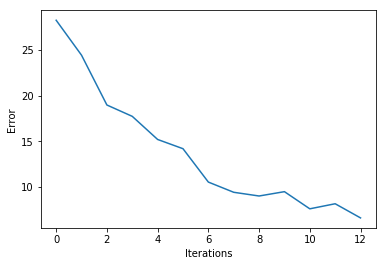

Validation error plot


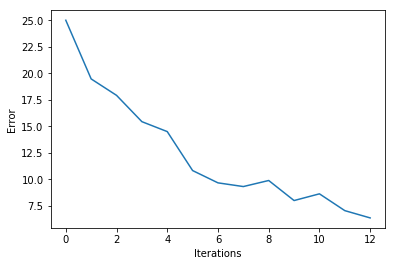

Test set accuracy: 0.5385714285714286

Predictions: [[1.55536539e-19 1.00000000e+00 7.12256616e-25 ... 1.10844321e-13
  5.22377157e-19 1.86351068e-23]
 [3.02445591e-26 1.00000000e+00 1.44646822e-10 ... 5.68352320e-14
  9.95656169e-18 7.55524322e-29]
 [9.91580489e-07 9.70307275e-06 5.09731560e-12 ... 3.84658650e-03
  2.45763814e-03 2.42630858e-04]
 ...
 [1.50345195e-14 8.03577481e-15 4.89213983e-21 ... 9.99999984e-01
  7.03814741e-21 3.31952692e-17]
 [9.99673965e-01 5.31823013e-15 3.51125594e-16 ... 9.13334382e-10
  8.05601956e-13 9.33978268e-09]
 [8.04183910e-09 5.23885860e-18 3.19161507e-14 ... 3.28230831e-16
  9.60823881e-09 2.42799798e-14]]


In [59]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Random seed for reproducing - can be removed
# np.random.seed(123)

class Network:
    
    def __init__(self, alpha, input_count, hidden_count, output_count):
        self.alpha = alpha
        self.input_count = input_count
        self.hidden_count = hidden_count
        self.output_count = output_count
        self.val_err_list = []
        self.patience = 0
        self.current_index = 0
         
    def _softmax(self, z):
        # Stable softmax to counter over or underflow
        expz = np.exp(z)
        return expz / expz.sum(axis = 1, keepdims = True);
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x));
    
    def _sigmoid_derivative(self, z):
        return z * (1 - z);
    
    def init(self, X, Y, Y_hot, test_set_x, test_set_y, val_set_x, val_set_y, epochs):
        '''The function initializes random weights and 
        biases for the network, trains the network, and predicts 
        the XOR values of the inputs.
        '''
        self.w1 = np.random.randn(self.input_count, self.hidden_count)
        self.b1 = np.random.randn(self.hidden_count)
        
        self.w2 = np.random.randn(self.hidden_count, self.output_count)
        self.b2 = np.random.randn(self.output_count)
        
        errors = self.train(X, Y, Y_hot, val_set_x, val_set_y, epochs)
        
        # Training error plot
        print('Training error plot')
        fig, ax = plt.subplots()
        plt.plot(errors)
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Error")
        plt.show()
        
        # Validation error plot
        val_errors = self.val_err_list
        print("Validation error plot")
        fig2, ax2 = plt.subplots()
        plt.plot(val_errors)
        ax2.set_xlabel("Iterations")
        ax2.set_ylabel("Error")
        plt.show()
        
        # Test set accuracy
        self.test_accuracy(test_set_x, test_set_y)
        
        pred = self.predict(X)
        print('Predictions:', pred)
        
    def predict(self, X):
        '''This function predicts the XOR values using the final 
        weights and biases.
        '''        
        h1 = self._sigmoid(np.dot(X, self.w1) + self.b1)
        output = self._softmax(np.dot(h1, self.w2) + self.b2)         
        return output;
    
    # Mean Squared Error 
    def mse(self, y_label, y_pred):
        return np.square(y_pred - y_label)
    
    # NEGATIVE LOG LIKELIHOOD
    def nll(self, m, Y_hot, Y_pred):
        return -(np.sum(Y_hot * np.log(Y_pred))) / m;

    def forward_pass(self, X):
        # Input -> K1; get the dot product of the weights with input and add bias
        h1 = self._sigmoid(np.dot(X, self.w1) + self.b1)
        
        # K1 -> Output layer; get the dot product  of the weights with input and add bias
        output = self._softmax(np.dot(h1, self.w2) + self.b2)
        
        # Apply softmax activation function on resultant z and return
        return h1, output;
    

    def train(self, X, Y, Y_hot, val_set_x, val_set_y, epochs):
        '''The function performs a forward pass to obtain the 
        activation vectors, then computes the error that needs to be
        minimized, and then performs backward propagation to
        acquire the deltas using sigmoid prime, and then
        updates the weights.
        '''
        
        errors = []
        early_stopping = False
        for epoch in range(epochs):
            print('Epoch', epoch) 
            # Forward pass to get outputs
            h1, Y_pred = self.forward_pass(X)

            # Back propagation
            d2 = Y_pred - Y_hot
            d1 = np.dot(d2, self.w2.T) * self._sigmoid_derivative(h1)
            
            # Update weights and biases
            self.w2 -= self.alpha * np.dot(h1.T, d2)
            self.b2 -= self.alpha * np.sum(d2, axis = 0)

            self.w1 -= self.alpha * np.dot(X.T, d1)
            self.b1 -= self.alpha * np.sum(d1, axis = 0)

#             if epoch % 1000 == 0:
            # Number of input patterns
            m = X.shape[0]

            # Negative log likelihood error function
            error = self.nll(m, Y_hot, Y_pred)

            errors.append(error)
                
            # Early stopping with validation set
            if self.early_stopping(val_set_x, val_set_y) == True:
                return errors;
            
        return errors;
    
    def test_accuracy(self, test_set_x, test_set_y):
        h1 = self._sigmoid(np.dot(test_set_x, self.w1) + self.b1)
        output = self._softmax(np.dot(h1, self.w2) + self.b2)
        size = test_set_y.shape[0]
        val_accuracy = len(test_set_y[np.argmax(output, axis = 1) == np.argmax(test_set_y, axis = 1)]) / size
        print("Test set accuracy:", val_accuracy)
        print()
        
    def early_stopping(self, val_set_x, val_set_y):
        m = val_set_x.shape[0]
        h1 = self._sigmoid(np.dot(val_set_x, self.w1) + self.b1)
        output = self._softmax(np.dot(h1, self.w2) + self.b2)
        
        val_err = self.nll(m, val_set_y, output)
        self.val_err_list.append(val_err)
        print('Validation err:', val_err)
        if len(self.val_err_list) > 1:
            delta = self.val_err_list[self.current_index] - self.val_err_list[self.current_index - 1]
            if delta <= 0:
                self.patience += 1

            if self.patience == 10:
                return True;
            
        self.current_index += 1
        
# Using MNIST data
mynetwork = Network(0.00001, 784, 1000, 10)
mynetwork.init(train_set_x, train_y, train_set_y, 
               test_set_x, test_set_y, val_set_x, 
               val_set_y, 50000)





## Question 4

Conventionally, softmax is utilized for multi-class tasks, whereas sigmoid is utilized for binary classification. Sigmoid ranges from 0 to 1 and have outputs that are independent, whereas softmax produces class probability distributions that sum up to 1. Negative log likelihood, also known as cross entropy is a common alternative squared error technique with softmax activations because negative log likelihoods works well with probability distributions, and node activations can be represented where either hypothesis can be true. If instead of using softmax activation and negative log likelihood cost, we use sigmoidal activation functions for the output units and the sum of square error of each output then I would expect that the outputs of the sigmoid function with mean squared error cost would be independent from each other (0 to 1), increase chances of stalling in training (in comparison to softmax), and the model would be less accurate. By using negative log likelihood with softmax activation helps remove the term (y * (1 - y) )in the equation, which helps prevent stallout in training because if y is high in this term then the resulting term value in the gradient gets much smaller. In addition, mean squared error with this dataset can be inaccurate as would emphasizes the errors in the output too much. With this dataset being a multi-class problem, it would make sense to use softmax and negative log likelihood for the listed reasons. For example, if the output is 0.8, the weight adjustments get much smaller, which could. Hence, using softmax and negative likelihood for this dataset is more likely to reduce stallout and improve accuracy as it removes. Furthermore, choosing these hyper parameters are highly dependent upon what you are looking to solve.

## Question 5

If instead of using softmax activation and negative log likelihood cost, we use a single linear output unit trained on the actual class number using sum squared error cost I would expect that the single linear output unit with sum squared error (e.g., ReLu, linear regression) could suffer from the vanishing gradient problem, which will prevent the weights from further adjusting, and the network will not converge. The reason why this may happen with a single linear output unit with a sum squared error is due to the unbounded nature of the function. In addition, if the training does complete I would expect the result to be inaccurate because the value is unbounded and not a probability distribution. For example, in ReLu (i.e., max(0,y)) the output is unbounded and could produce a high value that is greater than 1, which could mislead the classification by associating a high value with the most desirable class, when it may actually not be.